<a href="https://colab.research.google.com/github/dhruvmalik007/100-days-of-code/blob/master/xAI_lablab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LabLab DOGE hackathon submission preparation


Project-name: astute government accountant




Idea: its an multiagent orchestrator dashboard integrated with the chat UI which allow users to do modelling of government accounting by:  


- parsing the data across the government agencies [websites](https://www.usa.gov/state-local-governments).

- pdf of the US government budget.

- [fiscale debt of the US government](https://api.fiscaldata.treasury.gov/services/api/fiscal_service/).

- [federal contracts](https://sam.gov/) for checking the defense and other massive spending.

- [OMB](https://omb.gov): for the audits agency of the US government.

And then essentially it creates the gamification for multiple users to get the consensus on how to cut the budget by coming with the meticuluous analysis report of the potential budget cuts across the domains.





## Architecture-diagram:

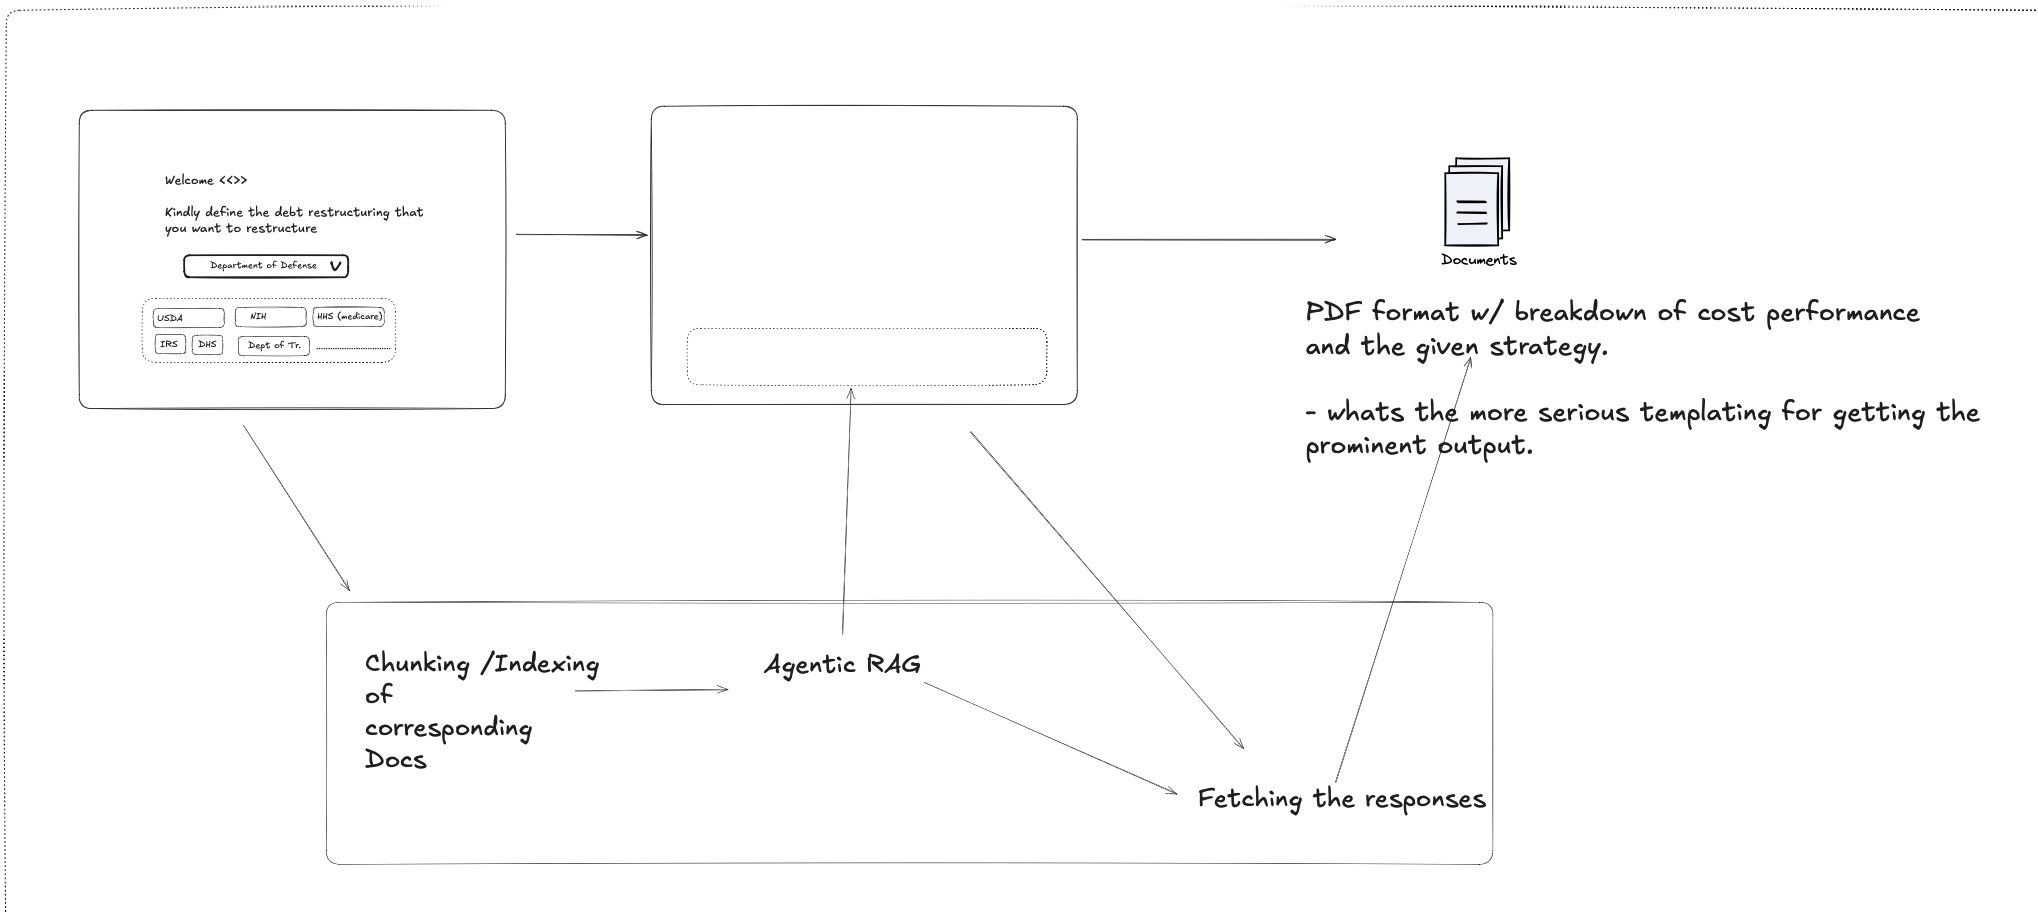














1. Creating the user pipeline by parsing the given URL's and setting up the agent prompts.

In [10]:
!pip install firecrawl-py==0.0.20 langchain langgraph openai langchain-community tiktoken langchain-weaviate weaviate

In [42]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.6 MB/s eta 0:00:00


In [14]:
!pip install pytest-playwright
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 17.9 MB/s eta 0:00:00
161.3 MiB [] 0% 0.0s161.3 MiB [] 0% 37.4s161.3 MiB [] 0% 36.2s161.3 MiB [] 0% 16.4s161.3 MiB [] 0% 13.8s161.3 MiB [] 0% 9.2s161.3 MiB [] 1% 7.1s161.3 MiB [] 1% 5.9s161.3 MiB [] 2% 5.3s161.3 MiB [] 2% 5.0s161.3 MiB [] 3% 4.6s161.3 MiB [] 4% 4.2s161.3 MiB [] 4% 3.9s161.3 MiB [] 5% 3.8s161.3 MiB [] 5% 3.7s161.3 MiB [] 6% 3.6s161.3 MiB [] 6% 3.9s161.3 MiB [] 7% 4.0s161.3 MiB [] 7% 3.9s161.3 MiB [] 8% 3.8s161.3 MiB [] 9% 3.6s161.3 MiB [] 9% 3.5s161.3 MiB [] 9% 3.6s161.3 MiB [] 10% 3.6s161.3 MiB [] 11% 3.6s161.3 MiB [] 11% 3.5s161.3 MiB [] 12% 3.4s161.3 MiB [] 12% 3.3s161.3 MiB [] 13% 3.2s161.3 MiB [] 14% 3.2s161.3 MiB [] 15% 3.2s161.3 MiB [] 16% 3.1s161.3 MiB [] 17% 3.0s161.3 MiB [] 18% 3.0s161.3 MiB [] 19% 2.9s161.3 MiB [] 20% 2.8s161.3 MiB [] 21% 2.7s161.3 MiB [] 22% 2.7s161.3 MiB [] 23% 2.7s161.3 MiB [] 24% 2.7s161.3 MiB [] 24% 2.6s161.3 MiB [] 25% 2.6s161.3 MiB [] 26% 2.5s161.3 MiB [] 27% 2.4s161.3 MiB [] 28%

In [63]:
!pip install gdown

In [13]:
from google.colab import userdata, drive
from langchain_community.document_loaders import FireCrawlLoader
import weaviate
import os
import json

def get_env_token(env_var: str):
  """Fetches the XAI_TOKEN environment variable from secrets.

  Returns:
      str: The value of the XAI_TOKEN environment variable.
      None: If the variable is not set.
  """
  try:
    os.environ[env_var] = userdata.get(env_var)
  except KeyError:
    return None

crawling_URLS = [
    {
        "Sam_govt": "https://sam.gov"
    },
    {
        "agencies_index": "https://www.usa.gov/agency-index"
    }
]


get_env_token("FIRECRAWL_API_KEY")

firecrawl_params = FireCrawlLoader(api_key=os.environ["FIRECRAWL_API_KEY"], url="https://www.usa.gov/agency-index", mode="scrape")
data = firecrawl_params.load()


## storing the crawled file into txt format
with open("data.txt", "w") as f:
  f.write(str(data))

In [40]:

## now writing the functions to parse only the agencies from the given page
import asyncio
from playwright.async_api import async_playwright

## storing the agency parameters from the given file

async def all_agency_links(index_url):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)  # Launch headless browser
        page = await browser.new_page()

        # Navigate to the index page
        await page.goto(index_url)

        # Click on each index link (A-Z) and scrape agency links
        agency_links = []
        index_links = await page.query_selector_all('a[href^="/agency-index/"]')  # Selects all A-Z links

        for link_href in [await link.get_attribute('href') for link in index_links]:
            # Navigate to the index page
            await page.goto(f"https://www.usa.gov{link_href}")

            # Scrape agency links from the current index page
            current_agency_links = await page.evaluate('''() => {
                return Array.from(document.querySelectorAll('a[href^="https://www."]')) // Selects all agency links
                    .map(link => link.href);
            }''')

            agency_links.extend(current_agency_links)  # Add found links to the list

        await browser.close()

    return agency_links

output_test = await all_agency_links("https://www.usa.gov/agency-index")
## storing the result as txt file named urls_usa_govt.txt

print(output_test)


['https://www.uscourts.gov/services-forms/bankruptcy', 'https://www.uscourts.gov/about-federal-courts/federal-courts-public/court-website-links#districtbankruptcy', 'https://www.uscourts.gov/federal-court-finder/search', 'https://www.bpa.gov/', 'https://www.bpa.gov/about/who-we-are/contact-form', 'https://www.usbg.gov/visit/hours-and-location', 'https://www.ttb.gov/', 'https://www.ttb.gov/about-ttb/contact-us', 'https://www.ttb.gov/trade-investigations/tid-map', 'https://www.atf.gov/', 'https://www.atf.gov/contact', 'https://www.consumerfinance.gov/', 'https://www.consumerfinance.gov/about-us/contact-us/', 'https://www.bea.gov/', 'https://www.bea.gov/help/contact-us', 'https://www.moneyfactory.gov/', 'https://www.bep.gov/contact-us', 'https://www.bia.gov/', 'https://www.bia.gov/contact-us', 'https://www.bia.gov/regional-offices', 'https://www.bis.doc.gov/', 'https://www.bis.doc.gov/index.php/about-bis/contact-bis', 'https://www.dol.gov/agencies/ilab', 'https://www.dol.gov/general/conta

In [45]:
from collections import defaultdict
import tldextract

async def group_urls_by_middle_text(urls):
    """
    Groups URLs by their middle text (e.g., "abc" in "www.abc.gov")
    and returns a dictionary with middle text as keys and base URLs as values.

    Args:
        urls (list): A list of URLs.

    Returns:
        dict: A dictionary where keys are middle texts and values are base URLs.
    """
    grouped_urls = {}

    for url in urls:
        extracted = tldextract.extract(url)  # Extract domain information
        middle_text = extracted.domain  # Use the domain as the middle text

        # Construct base URL and add to dictionary if it's new for this middle text
        base_url = f"https://{extracted.subdomain}.{extracted.domain}.{extracted.suffix}" if extracted.subdomain else f"https://{extracted.domain}.{extracted.suffix}"
        if middle_text not in grouped_urls:
            grouped_urls[middle_text] = base_url

    return grouped_urls


# Example usage
index_url = "https://www.usa.gov/agency-index"

agency_links = await all_agency_links(index_url)  # Get the list of agency links

grouped_agency_links = await group_urls_by_middle_text(agency_links)  # Group URLs by base domain

## storing the result as the json file

# Store the dictionary in a JSON file
with open('agency_links_listing.json', 'w') as json_file:
    json.dump(grouped_agency_links, json_file, indent=4)



# Print the grouped URLs
for index, base_url in grouped_agency_links.items():
    print(f"Index {index}: [{base_url}]")





/usr/lib/python3.10/asyncio/base_events.py:773: RuntimeWarning: coroutine 'scrape_agency_links' was never awaited
  handle = events.Handle(callback, args, self, context)


Index uscourts: [https://www.uscourts.gov]
Index bpa: [https://www.bpa.gov]
Index usbg: [https://www.usbg.gov]
Index ttb: [https://www.ttb.gov]
Index atf: [https://www.atf.gov]
Index consumerfinance: [https://www.consumerfinance.gov]
Index bea: [https://www.bea.gov]
Index moneyfactory: [https://www.moneyfactory.gov]
Index bep: [https://www.bep.gov]
Index bia: [https://www.bia.gov]
Index doc: [https://www.bis.doc.gov]
Index dol: [https://www.dol.gov]
Index bjs: [https://www.bjs.gov]
Index bls: [https://www.bls.gov]
Index blm: [https://www.blm.gov]
Index boem: [https://www.boem.gov]
Index bop: [https://www.bop.gov]
Index usbr: [https://www.usbr.gov]
Index bsee: [https://www.bsee.gov]
Index census: [https://www.census.gov]
Index treasury: [https://www.fiscal.treasury.gov]
Index bts: [https://www.bts.gov]
Index facebook: [https://www.facebook.com]
Index youtube: [https://www.youtube.com]
Index instagram: [https://www.instagram.com]
Index gsa: [https://www.gsa.gov]
Index uscp: [https://www.

In [71]:
## now parsing the pdf's from the OMB in order to analyse the fiscal budget and obligations information
### the outputs will be :
### PDF documents with their indexation in the google drive
### json file that stores the mapping for the given fiscal year and all


import asyncio
from playwright.async_api import async_playwright
import json
import google.auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
import gdown



import asyncio

# Mount Google Drive (if not already mounted)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


#drive.mount('/content/drive')

# Define the base directory for storing documents
BASE_DIR = '/content/drive/MyDrive/OMB-docs'

# Create the base directory if it doesn't exist
os.makedirs(BASE_DIR, exist_ok=True)
os.chdir(BASE_DIR)

async def scrape_budget_fiscal_years():
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()
        await page.goto('https://www.govinfo.gov/app/collection/budget')

        # Loop through fiscal years from 2025 to 2015
        for year in range(2025, 2014, -1):
            fiscal_year_selector = f'span:has-text("Fiscal Year {year}")'
            await page.wait_for_selector(fiscal_year_selector)
            await page.click(fiscal_year_selector)

            # Wait for the content to load after clicking
            await page.wait_for_timeout(2000)  # Adjust if necessary



            # Here you would typically extract links or perform further actions
            # For example, if there are PDF links to download:
            pdf_links = await page.query_selector_all('a[href$=".pdf"]')
            for pdf_link in pdf_links:
                pdf_url = await pdf_link.get_attribute('href')
                print(f'Downloading PDF for Fiscal Year {year}: {pdf_url}')


                ##https://www.govinfo.gov/content/pkg/BUDGET-2025-BUD/pdf/BUDGET-2025-BUD.pdf
                # Use gdown to download the file
                gdown.download("https://www.govinfo.gov/" + pdf_url, quiet=False)

            # Go back to the main budget page to select the next year
            await page.go_back()

        await browser.close()

# Run the scraping function
await scrape_budget_fiscal_years()


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-BUD/pdf/BUDGET-2025-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-BUD.pdf
100%|██████████| 2.50M/2.50M [00:01<00:00, 2.10MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-BUD/pdf/BUDGET-2025-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-BUD.pdf


100%|██████████| 2.50M/2.50M [00:04<00:00, 592kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-PER/pdf/BUDGET-2025-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-PER.pdf


100%|██████████| 8.79M/8.79M [00:22<00:00, 390kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-PER/pdf/BUDGET-2025-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-PER.pdf


100%|██████████| 8.79M/8.79M [00:03<00:00, 2.56MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-APP/pdf/BUDGET-2025-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-APP.pdf


100%|██████████| 14.9M/14.9M [00:05<00:00, 2.55MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-APP/pdf/BUDGET-2025-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-APP.pdf
100%|██████████| 14.9M/14.9M [01:10<00:00, 211kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-FCS/pdf/BUDGET-2025-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-FCS.pdf
100%|██████████| 1.79M/1.79M [00:03<00:00, 560kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-OBJCLASS/pdf/BUDGET-2025-OBJCLASS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-OBJCLASS.pdf


100%|██████████| 1.22M/1.22M [00:00<00:00, 2.26MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-BALANCES/pdf/BUDGET-2025-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-BALANCES.pdf


100%|██████████| 854k/854k [00:00<00:00, 2.40MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-BALANCES/pdf/BUDGET-2025-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-BALANCES.pdf
100%|██████████| 854k/854k [00:00<00:00, 1.12MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2025-MSR/pdf/BUDGET-2025-MSR.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2025-MSR.pdf
100%|██████████| 1.03M/1.03M [00:00<00:00, 1.58MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-BUD/pdf/BUDGET-2024-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-BUD.pdf


100%|██████████| 2.42M/2.42M [00:01<00:00, 2.36MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-BUD/pdf/BUDGET-2024-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-BUD.pdf
100%|██████████| 2.42M/2.42M [00:01<00:00, 1.70MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-PER/pdf/BUDGET-2024-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-PER.pdf


100%|██████████| 6.29M/6.29M [00:03<00:00, 2.01MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-PER/pdf/BUDGET-2024-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-PER.pdf
100%|██████████| 6.29M/6.29M [00:03<00:00, 1.68MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-APP/pdf/BUDGET-2024-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-APP.pdf


100%|██████████| 15.9M/15.9M [00:38<00:00, 410kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-APP/pdf/BUDGET-2024-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-APP.pdf


100%|██████████| 15.9M/15.9M [00:31<00:00, 501kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-FCS/pdf/BUDGET-2024-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-FCS.pdf


100%|██████████| 1.81M/1.81M [00:00<00:00, 2.67MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-OBJCLASS/pdf/BUDGET-2024-OBJCLASS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-OBJCLASS.pdf


100%|██████████| 1.63M/1.63M [00:00<00:00, 2.38MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-BALANCES/pdf/BUDGET-2024-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-BALANCES.pdf


100%|██████████| 825k/825k [00:03<00:00, 246kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-BALANCES/pdf/BUDGET-2024-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-BALANCES.pdf


100%|██████████| 825k/825k [00:00<00:00, 2.42MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2024-MSR/pdf/BUDGET-2024-MSR.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2024-MSR.pdf


100%|██████████| 1.18M/1.18M [00:00<00:00, 1.83MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-BUD/pdf/BUDGET-2023-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-BUD.pdf


100%|██████████| 2.78M/2.78M [00:01<00:00, 2.57MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-BUD/pdf/BUDGET-2023-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-BUD.pdf


100%|██████████| 2.78M/2.78M [00:01<00:00, 2.65MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-PER/pdf/BUDGET-2023-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-PER.pdf


100%|██████████| 6.38M/6.38M [00:09<00:00, 706kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-PER/pdf/BUDGET-2023-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-PER.pdf


100%|██████████| 6.38M/6.38M [00:02<00:00, 2.47MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-APP/pdf/BUDGET-2023-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-APP.pdf


100%|██████████| 15.3M/15.3M [00:21<00:00, 710kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-APP/pdf/BUDGET-2023-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-APP.pdf
100%|██████████| 15.3M/15.3M [00:06<00:00, 2.52MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-FCS/pdf/BUDGET-2023-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-FCS.pdf


100%|██████████| 2.23M/2.23M [00:00<00:00, 2.31MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-FCS/pdf/BUDGET-2023-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-FCS.pdf


100%|██████████| 2.23M/2.23M [00:00<00:00, 2.35MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-OBJCLASS/pdf/BUDGET-2023-OBJCLASS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-OBJCLASS.pdf


100%|██████████| 1.54M/1.54M [00:00<00:00, 2.28MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-BALANCES/pdf/BUDGET-2023-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-BALANCES.pdf


100%|██████████| 695k/695k [00:00<00:00, 2.31MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-BALANCES/pdf/BUDGET-2023-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-BALANCES.pdf


100%|██████████| 695k/695k [00:00<00:00, 3.03MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2023-MSR/pdf/BUDGET-2023-MSR.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2023-MSR.pdf
100%|██████████| 1.58M/1.58M [00:01<00:00, 1.53MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-BUD/pdf/BUDGET-2022-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-BUD.pdf


100%|██████████| 3.80M/3.80M [00:06<00:00, 547kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-BUD/pdf/BUDGET-2022-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-BUD.pdf


100%|██████████| 3.80M/3.80M [00:15<00:00, 242kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-PER/pdf/BUDGET-2022-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-PER.pdf
100%|██████████| 3.54M/3.54M [00:05<00:00, 646kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-PER/pdf/BUDGET-2022-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-PER.pdf
100%|██████████| 3.54M/3.54M [00:02<00:00, 1.75MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-APP/pdf/BUDGET-2022-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-APP.pdf


100%|██████████| 15.5M/15.5M [00:24<00:00, 621kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-APP/pdf/BUDGET-2022-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-APP.pdf


100%|██████████| 15.5M/15.5M [00:06<00:00, 2.40MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-FCS/pdf/BUDGET-2022-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-FCS.pdf


100%|██████████| 1.51M/1.51M [00:03<00:00, 459kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-FCS/pdf/BUDGET-2022-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-FCS.pdf
100%|██████████| 1.51M/1.51M [00:00<00:00, 1.51MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-OBJCLASS/pdf/BUDGET-2022-OBJCLASS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-OBJCLASS.pdf


100%|██████████| 1.39M/1.39M [00:00<00:00, 1.49MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-BALANCES/pdf/BUDGET-2022-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-BALANCES.pdf


100%|██████████| 629k/629k [00:00<00:00, 873kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-BALANCES/pdf/BUDGET-2022-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-BALANCES.pdf
100%|██████████| 629k/629k [00:00<00:00, 1.26MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2022-MSR/pdf/BUDGET-2022-MSR.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2022-MSR.pdf
100%|██████████| 643k/643k [00:00<00:00, 1.34MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-BUD/pdf/BUDGET-2021-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-BUD.pdf


100%|██████████| 2.08M/2.08M [00:07<00:00, 296kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-BUD/pdf/BUDGET-2021-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-BUD.pdf
100%|██████████| 2.08M/2.08M [00:01<00:00, 1.57MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-PER/pdf/BUDGET-2021-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-PER.pdf


100%|██████████| 4.91M/4.91M [00:02<00:00, 2.13MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-PER/pdf/BUDGET-2021-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-PER.pdf
100%|██████████| 4.91M/4.91M [00:11<00:00, 422kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-APP/pdf/BUDGET-2021-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-APP.pdf
100%|██████████| 15.6M/15.6M [00:07<00:00, 2.18MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-APP/pdf/BUDGET-2021-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-APP.pdf


100%|██████████| 15.6M/15.6M [00:26<00:00, 595kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-MSV/pdf/BUDGET-2021-MSV.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-MSV.pdf


100%|██████████| 2.33M/2.33M [00:00<00:00, 2.81MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-TAB/pdf/BUDGET-2021-TAB.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-TAB.pdf


100%|██████████| 6.75M/6.75M [00:02<00:00, 2.43MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-TAB/pdf/BUDGET-2021-TAB.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-TAB.pdf
100%|██████████| 6.75M/6.75M [00:04<00:00, 1.66MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-FCS/pdf/BUDGET-2021-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-FCS.pdf


100%|██████████| 2.96M/2.96M [00:01<00:00, 2.36MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-FCS/pdf/BUDGET-2021-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-FCS.pdf


100%|██████████| 2.96M/2.96M [00:01<00:00, 2.10MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-OBJCLASS/pdf/BUDGET-2021-OBJCLASS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-OBJCLASS.pdf


100%|██████████| 2.01M/2.01M [00:00<00:00, 2.65MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-BALANCES/pdf/BUDGET-2021-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-BALANCES.pdf


100%|██████████| 735k/735k [00:00<00:00, 2.01MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-BALANCES/pdf/BUDGET-2021-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-BALANCES.pdf
100%|██████████| 735k/735k [00:00<00:00, 1.86MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2021-MSR/pdf/BUDGET-2021-MSR.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2021-MSR.pdf


100%|██████████| 983k/983k [00:00<00:00, 1.70MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-BUD/pdf/BUDGET-2020-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-BUD.pdf
100%|██████████| 2.11M/2.11M [00:01<00:00, 1.71MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-BUD/pdf/BUDGET-2020-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-BUD.pdf


100%|██████████| 2.11M/2.11M [00:03<00:00, 546kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-PER/pdf/BUDGET-2020-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-PER.pdf


100%|██████████| 6.90M/6.90M [00:03<00:00, 2.15MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-PER/pdf/BUDGET-2020-PER.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-PER.pdf


100%|██████████| 6.90M/6.90M [00:12<00:00, 547kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-APP/pdf/BUDGET-2020-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-APP.pdf
100%|██████████| 14.7M/14.7M [00:23<00:00, 626kB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-APP/pdf/BUDGET-2020-APP.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-APP.pdf
100%|██████████| 14.7M/14.7M [00:08<00:00, 1.79MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-MSV/pdf/BUDGET-2020-MSV.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-MSV.pdf
100%|██████████| 3.27M/3.27M [00:01<00:00, 2.03MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-TAB/pdf/BUDGET-2020-TAB.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-TAB.pdf


100%|██████████| 3.24M/3.24M [00:02<00:00, 1.43MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-TAB/pdf/BUDGET-2020-TAB.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-TAB.pdf
100%|██████████| 3.24M/3.24M [00:08<00:00, 396kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-FCS/pdf/BUDGET-2020-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-FCS.pdf


100%|██████████| 2.01M/2.01M [00:00<00:00, 2.43MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-FCS/pdf/BUDGET-2020-FCS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-FCS.pdf
100%|██████████| 2.01M/2.01M [00:07<00:00, 274kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-OBJCLASS/pdf/BUDGET-2020-OBJCLASS.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-OBJCLASS.pdf


100%|██████████| 1.55M/1.55M [00:02<00:00, 597kB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-BALANCES/pdf/BUDGET-2020-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-BALANCES.pdf


100%|██████████| 454k/454k [00:00<00:00, 1.88MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-BALANCES/pdf/BUDGET-2020-BALANCES.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-BALANCES.pdf


100%|██████████| 454k/454k [00:00<00:00, 1.82MB/s]


Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2020-MSR/pdf/BUDGET-2020-MSR.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2020-MSR.pdf
100%|██████████| 6.22M/6.22M [00:03<00:00, 1.61MB/s]
Downloading...
From: https://www.govinfo.gov//content/pkg/BUDGET-2019-BUD/pdf/BUDGET-2019-BUD.pdf
To: /content/drive/MyDrive/OMB-docs/BUDGET-2019-BUD.pdf


100%|██████████| 2.42M/2.42M [00:02<00:00, 948kB/s]


CancelledError: 

In [51]:
## now setting up the xAI grok model access along with the embeddings of these models.

get_env_token("XAI_TOKEN")

from langchain_community.document_loaders import PyPDFLoader







